# Moving Average Crossover Strategy

##### LONG: long-term period moving average price

##### SHORT: short-term period moving average price

##### If SHORT > LONG, go long the stock;

##### If SHORT < LONG, go short the stock.

## Quick Backtesting:
### This is an example of applying self-written "quickBacktesting" Package to backtest a simple double moving average strategy. 

The inner logits, including computing positions and total portfolio values, are packaged in code already. Hence, the only thing we need to do is to inherit the template class "QuickStrategy" and re-write the function "generate_signals" to control the signals('long', 'short', 'sell' and 'cover').

In [1]:
import datetime
import matplotlib as mpl 
mpl.rcParams['font.family'] = 'serif' 
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import sys
sys.path.append('C:/Users/acer/Desktop/BigW')
from quickBacktesting.quickStrategy import *
from quickBacktesting.quickBacktestEngine import *

# Download data from yahoo
def yahooFinanceDownload(ticker):
    '''Download daily stock prices for a single stock from Yahoo! Finance and reserve data as CSV to specific filepath.

    Args:
        ticker(str): Ticker
        filepath(str): Filepath to output and reserve CSV
    '''
    start_date= datetime.datetime(2000,1,1)
    end_date = datetime.date.today()
    prices = yf.download(ticker, start=start_date, end=end_date)
    return prices

class MovingAverageCrossStrategy(QuickStrategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average."""

    def __init__(self, symbol, bars, short_window=100, long_window=400):
        self.symbol = symbol
        self.bars = bars

        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0

        # Create the set of short and long simple moving averages over the 
        # respective periods
        signals['short_mavg'] = bars['Close'].rolling(self.short_window).mean()
        signals['long_mavg'] = bars['Close'].rolling(self.long_window).mean()

        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
            > signals['long_mavg'][self.short_window:], 1.0, 0.0)   

        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()   

        return signals

In [2]:
symbol = 'AAPL'
bars = yahooFinanceDownload(symbol)
mac = MovingAverageCrossStrategy(symbol, bars, short_window=100, long_window=400)
signals = mac.generate_signals()

[*********************100%***********************]  1 of 1 downloaded


In [3]:
signals.tail()

,signal,short_mavg,long_mavg,positions
Date,,,,
2018-11-06,1.0,208.900901,175.491125,0.0
2018-11-07,1.0,209.113001,175.657650,0.0
2018-11-08,1.0,209.341001,175.820950,0.0
2018-11-09,1.0,209.520701,175.978050,0.0
2018-11-12,1.0,209.607801,176.108975,0.0


In [4]:
quickEngine = QuickBacktestEngine()
returns = quickEngine.runBacktesting(symbol, bars, signals, initial_capital=100000.0)

In [5]:
returns.tail()

,signal,position_diff,close,holdings,cash,total,portfolio_returns
Date,,,,,,,
2018-11-06,100.0,0.0,203.770004,20377.0004,96269.3571,116646.3575,0.001872
2018-11-07,100.0,0.0,209.949997,20994.9997,96269.3571,117264.3568,0.005298
2018-11-08,100.0,0.0,208.490005,20849.0005,96269.3571,117118.3576,-0.001245
2018-11-09,100.0,0.0,204.470001,20447.0001,96269.3571,116716.3572,-0.003432
2018-11-12,100.0,0.0,194.169998,19416.9998,96269.3571,115686.3569,-0.008825


C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\acer\Anaconda3\lib\site

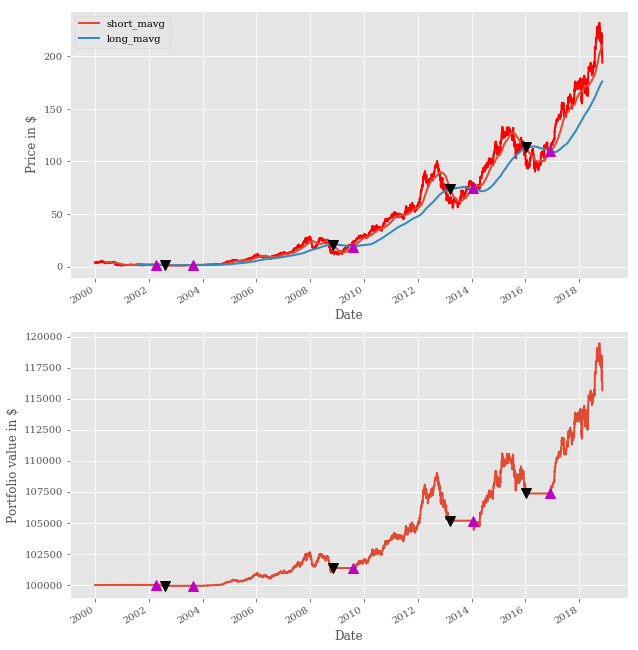

In [6]:
# Plot two charts to assess trades and equity curve
fig = plt.figure(figsize=(10,12))
fig.patch.set_facecolor('white')     # Set the outer colour to white
ax1 = fig.add_subplot(211,  ylabel='Price in $')

# Plot the AAPL closing price overlaid with the moving averages
bars['Close'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the "buy" trades against AAPL
ax1.plot(signals.ix[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')

# Plot the "sell" trades against AAPL
ax1.plot(signals.ix[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Plot the equity curve in dollars
ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
returns['total'].plot(ax=ax2, lw=2.)

# Plot the "buy" and "sell" trades against the equity curve
ax2.plot(returns.ix[signals.positions == 1.0].index, 
         returns.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax2.plot(returns.ix[signals.positions == -1.0].index, 
         returns.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Plot the figure
fig.show()

In [7]:
port_returns = returns['portfolio_returns']
equity_s = returns['total']

In [8]:
from quickBacktesting.quickStatistics import *

In [9]:
stat_engine = QuickStatistics(symbol, port_returns, equity_s, 'MA', rolling_sharpe=True)

C:\Users\acer\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\acer\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\acer\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


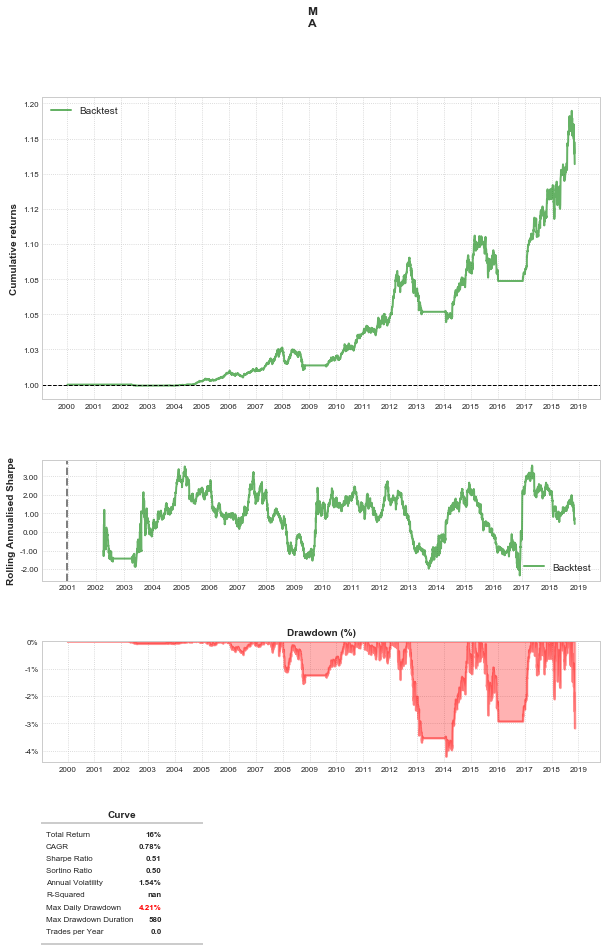

In [10]:
stat_engine.plot_results()